In [54]:
import numpy as np

In [5]:
import pandas as pd

STORMFRONT_DB = 'sqlite:////home/sam/data/stormfront/stormfront.sqlite'

df_authors = pd.read_sql_table('authors', STORMFRONT_DB)

In [14]:
df_post_times = pd.read_sql_query('SELECT author, post_date FROM posts', STORMFRONT_DB, parse_dates=['post_date'])

In [22]:
author_posts_by_hour = df_post_times.groupby(['author', pd.DatetimeIndex(df_post_times.post_date).hour]).count()

In [31]:
author_posts_total = df_post_times['author'].value_counts()

In [33]:
author_posts_total.head()

WhiteRights    26313
Glacier        10766
blueearth       8263
BoyHowdy        6854
guest           6718
Name: author, dtype: int64

In [52]:
author_posts_percentage = author_posts_by_hour.groupby(level=0).apply(lambda x: x / x.sum())

In [72]:
author_posts_percentage.ix['Glacier'].get(0)

In [107]:
hour_data = author_posts_percentage.unstack(level=1)['post_date'].reset_index().fillna(0)

In [109]:
hour_data.head()

,author,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,**JT**,0.103448,0.103448,0.103448,0.103448,0.0,0.034483,0.034483,0.034483,0.0,...,0.068966,0.0,0.0,0.034483,0.034483,0.068966,0.034483,0.068966,0.034483,0.103448
1,*Hither_Shore*,0.000000,0.500000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
2,*turtle_88*,0.100000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.2,0.0,0.000000,0.000000,0.000000,0.000000,0.100000,0.400000,0.100000
3,+213Theodoric+,0.000000,0.000000,0.333333,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.333333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,+dezelman+,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [119]:
import requests
r = requests.get('http://www.fonz.net/blog/wp-content/uploads/2008/04/states.csv')
from io import StringIO

states = pd.read_csv(StringIO(r.content.decode('ascii')))

In [125]:
lower_states = states.applymap(lambda x: x.lower())

lower_states.head()

,State,Abbreviation
0,alabama,al
1,alaska,ak
2,arizona,az
3,arkansas,ar
4,california,ca


In [126]:
lower_states.set_value?

In [127]:
for i, row in lower_states.iterrows():
    r = requests.get('http://openstates.org/api/v1/metadata/' + row.Abbreviation)
    tz = r.json()['capitol_timezone']
    
    lower_states.set_value(i, 'capitol_timezone', tz)
    
    print(i, row.Abbreviation, tz)

0 al America/Chicago
1 ak America/Anchorage
2 az America/Denver
3 ar America/Chicago
4 ca America/Los_Angeles
5 co America/Denver
6 ct America/New_York
7 de America/New_York
8 dc America/New_York
9 fl America/New_York
10 ga America/New_York
11 hi Pacific/Honolulu
12 id America/Denver
13 il America/Chicago
14 in America/Indiana/Indianapolis
15 ia America/Chicago
16 ks America/Chicago
17 ky America/New_York
18 la America/Chicago
19 me America/New_York
20 mt America/Denver
21 ne America/Chicago
22 nv America/Los_Angeles
23 nh America/New_York
24 nj America/New_York
25 nm America/Denver
26 ny America/New_York
27 nc America/New_York
28 nd America/North_Dakota/Center
29 oh America/New_York
30 ok America/Chicago
31 or America/Los_Angeles
32 md America/New_York
33 ma America/New_York
34 mi America/New_York
35 mn America/Chicago
36 ms America/Chicago
37 mo America/Chicago
38 pa America/New_York
39 ri America/New_York
40 sc America/New_York
41 sd America/Chicago
42 tn America/Chicago
43 tx Ameri

In [131]:
import datetime


-6.0

In [132]:
import pytz
import datetime

for i, row in lower_states.iterrows():
    offset = datetime.datetime.now(pytz.timezone(row.capitol_timezone)).utcoffset().total_seconds()/60/60
    lower_states.set_value(i, 'offset', offset)

In [147]:
author_tz_offsets = df_authors.merge(lower_states, left_on='primary_state', right_on='State', copy=False)[['author', 'offset']]

In [149]:
author_tz_offsets.offset.value_counts()

-5.0     1388
-6.0     1030
-8.0      527
-7.0      252
-9.0       15
-10.0       3
Name: offset, dtype: int64

In [164]:
hour_data_with_offset = hour_data.merge(author_tz_offsets, on='author')

In [175]:
hour_data_with_offset.shape, hour_data_with_offset[(hour_data_with_offset.offset != -10) & (hour_data_with_offset.offset != -9)].shape

((3215, 26), (3197, 26))

In [177]:
data = hour_data_with_offset[(hour_data_with_offset.offset != -10) & (hour_data_with_offset.offset != -9)]

In [178]:
Y, keys = pd.factorize(data.offset)

In [179]:
len(Y)

3197

In [180]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve



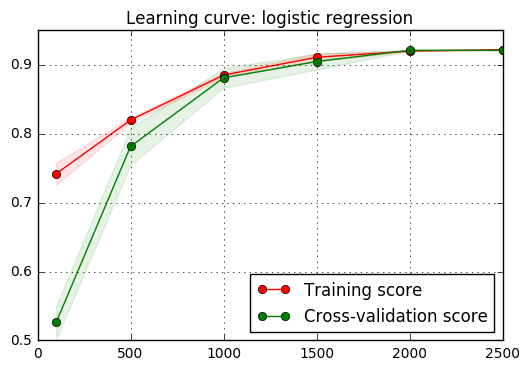

In [182]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_learning_curve(train_sizes, train_scores, valid_scores, name=''):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(valid_scores, axis=1)
    test_scores_std = np.std(valid_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.title('Learning curve: {}'.format(name))
    plt.show()
    
lr = LogisticRegression(n_jobs=-1, multi_class='ovr')
train_sizes, train_scores, valid_scores = learning_curve(lr, data.drop('author', 1), Y, train_sizes=[100, 500, 1000, 1500, 2000, 2500], cv=5)
plot_learning_curve(train_sizes, train_scores, valid_scores, 'logistic regression')

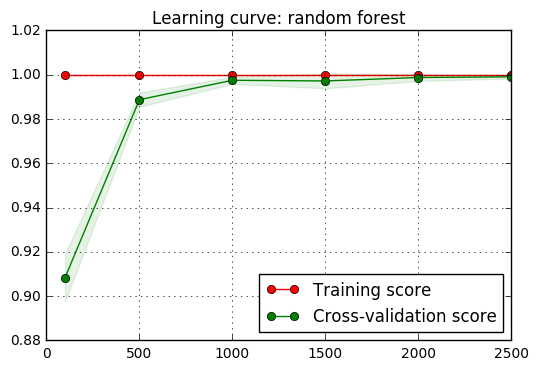

In [183]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
train_sizes, train_scores, valid_scores = learning_curve(rf, data.drop('author', 1), Y, train_sizes=[100, 500, 1000, 1500, 2000, 2500], cv=5)
plot_learning_curve(train_sizes, train_scores, valid_scores, 'random forest')

In [225]:
Y[Y == 0].shape

(527,)

In [227]:
y_score[]

(534, 4)

In [233]:
Y[test].shape

(534,)

In [235]:
roc_curve?

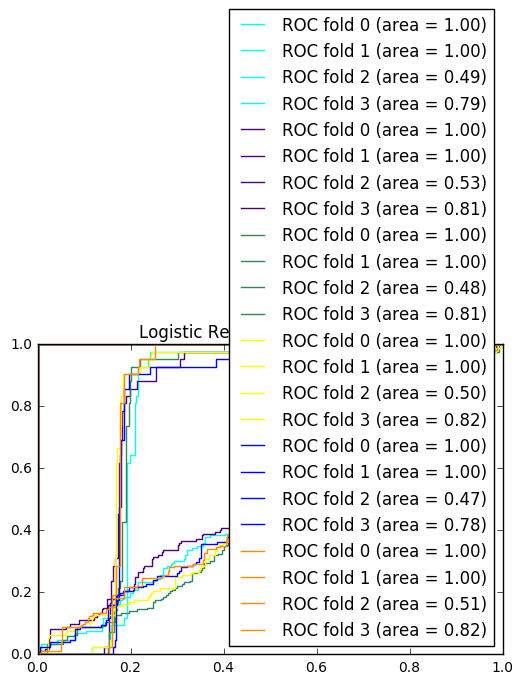

In [238]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from itertools import cycle

X = data.drop('author', 1).reset_index(drop=True)
cv = StratifiedKFold(n_splits=6)
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
for (train, test), color in zip(cv.split(X, Y), colors):    
    y_score = lr.fit(X.ix[train], Y[train]).decision_function(X.ix[test])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(Y[test], y_score[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc[i]))
        
plt.legend(loc='lower right')
plt.title('Logistic Regression ROC curves')

In [239]:
keys

Float64Index([-8.0, -5.0, -6.0, -7.0], dtype='float64')

In [ ]:
# The classifier succeeds at distinguishing east and west coast posters, 
# sometimes identifies mountain time, but not much else.

# Perhaps it should become just an east-coast/west-coast classifier instead.